In [1]:
!pip install gurobipy scikit-learn plotly









   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 76.8 MB/s eta 0:00:00




In [14]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from gurobipy import Model, GRB
import time
import random
import plotly.express as px

In [3]:
!kaggle datasets download -d mexwell/telecom-shanghai-dataset

Dataset URL: https://www.kaggle.com/datasets/mexwell/telecom-shanghai-dataset

License(s): other


 92%|█████████████████████████████████████▊   | 202M/219M [00:02<00:00, 141MB/s]

100%|█████████████████████████████████████████| 219M/219M [00:02<00:00, 102MB/s]


In [4]:
!unzip /kaggle/working/telecom-shanghai-dataset.zip

Archive:  /kaggle/working/telecom-shanghai-dataset.zip

  inflating: data_10.110.15.xlsx     

  inflating: data_10.1610.31.xlsx    

  inflating: data_11.111.15.xlsx     

  inflating: data_11.1611.30.xlsx    

  inflating: data_6.16.15.xlsx       

  inflating: data_6.166.30.xlsx      

  inflating: data_7.167.31.xlsx      

  inflating: data_7.17.15.xlsx       

  inflating: data_8.168.31.xlsx      

  inflating: data_8.18.15.xlsx       

  inflating: data_9.169.30.xlsx      

  inflating: data_9.19.15.xlsx       


In [5]:
dir_path = "/kaggle/working/"
df = pd.DataFrame()
for file_name in os.listdir(dir_path):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(dir_path,file_name)
        
        temp_df = pd.read_excel(file_path,engine='openpyxl')
        df = pd.concat([df,temp_df],ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 6952921 entries, 0 to 6952920

Data columns (total 7 columns):

 #   Column      Dtype         

---  ------      -----         

 0   month       int64         

 1   date        int64         

 2   start time  datetime64[ns]

 3   end time    datetime64[ns]

 4   latitude    float64       

 5   longitude   float64       

 6   user id     object        

dtypes: datetime64[ns](2), float64(2), int64(2), object(1)

memory usage: 371.3+ MB


In [19]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562779 entries, 0 to 562778
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   month       562779 non-null  int64         
 1   date        562779 non-null  int64         
 2   start time  562779 non-null  datetime64[ns]
 3   end time    562779 non-null  datetime64[ns]
 4   latitude    506586 non-null  float64       
 5   longitude   506586 non-null  float64       
 6   user id     562779 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 30.1+ MB


In [20]:
df_clean = df.dropna(subset = ['latitude','longitude'])
df_clean['latitude_norm'] = (df['latitude'] - df['latitude'].min()) / (df['latitude'].max() - df['latitude'].min())
df_clean['longitude_norm'] = (df['longitude'] - df['longitude'].min()) / (df['longitude'].max() - df['longitude'].min())
df_clean.info(show_counts=True)
df_clean.head()


<class 'pandas.core.frame.DataFrame'>
Index: 506586 entries, 236 to 561713
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   month           506586 non-null  int64         
 1   date            506586 non-null  int64         
 2   start time      506586 non-null  datetime64[ns]
 3   end time        506586 non-null  datetime64[ns]
 4   latitude        506586 non-null  float64       
 5   longitude       506586 non-null  float64       
 6   user id         506586 non-null  object        
 7   latitude_norm   506586 non-null  float64       
 8   longitude_norm  506586 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 38.6+ MB


/tmp/ipykernel_30/2964709305.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_30/2964709305.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,month,date,start time,end time,latitude,longitude,user id,latitude_norm,longitude_norm
236,201409,1,2014-09-01 11:24:15,2014-09-01 12:12:57,31.237872,121.470259,1709f1d6ad0d111ecedc9e64ab11437d,0.351016,0.653051
237,201409,1,2014-09-01 11:09:44,2014-09-01 11:19:42,31.237872,121.470259,e4f0a4b17da7d80b787f8e20a646954b,0.351016,0.653051
238,201409,1,2014-09-01 18:04:28,2014-09-01 18:04:48,31.237872,121.470259,5777dd8db181fa1364fdde9a490bc1c6,0.351016,0.653051
239,201409,1,2014-09-01 11:44:27,2014-09-01 11:45:23,31.237872,121.470259,e4f0a4b17da7d80b787f8e20a646954b,0.351016,0.653051
240,201409,1,2014-09-01 20:43:07,2014-09-01 20:53:51,31.237872,121.470259,f8206ab58b9bdb070673f7050242e9ee,0.351016,0.653051


In [16]:
base_stations = df_clean.groupby(['latitude', 'longitude']).size().reset_index(name='workload')
base_stations.info()
base_stations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705 entries, 0 to 2704
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   2705 non-null   float64
 1   longitude  2705 non-null   float64
 2   workload   2705 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 63.5 KB


,latitude,longitude,workload
0,22.522803,114.218796,285
1,24.284812,102.999068,266
2,25.222206,117.086322,49
3,26.139329,103.078562,1121
4,26.215115,109.744661,201


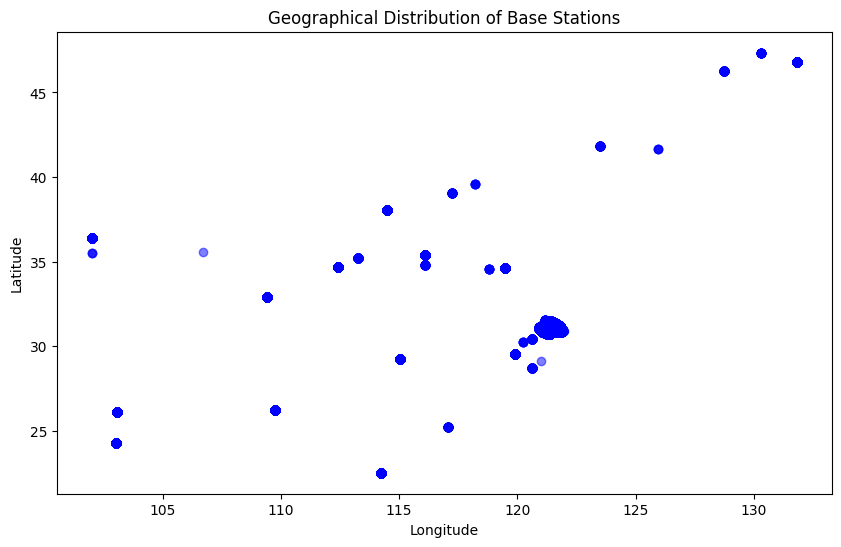

In [13]:
import matplotlib.pyplot as plt

# Geographical scatter plot of base stations
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['longitude'], df_clean['latitude'], c='blue', marker='o', alpha=0.5)
plt.title('Geographical Distribution of Base Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


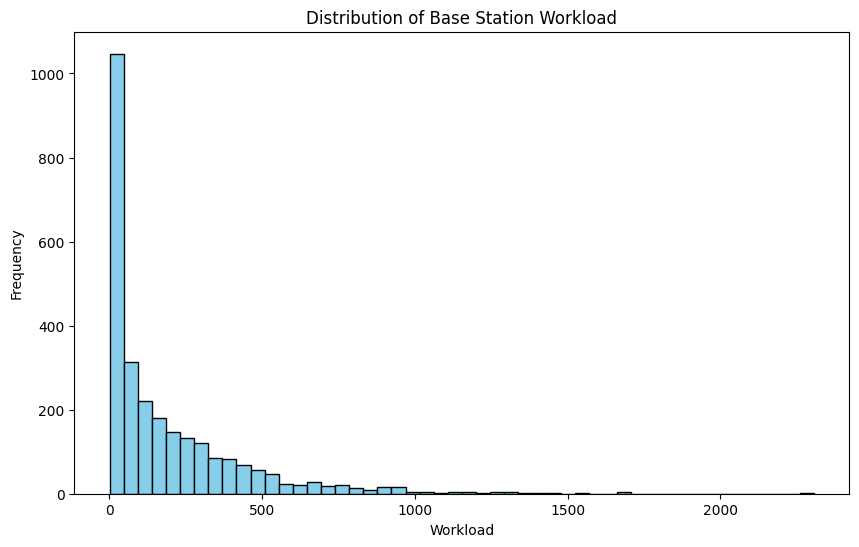

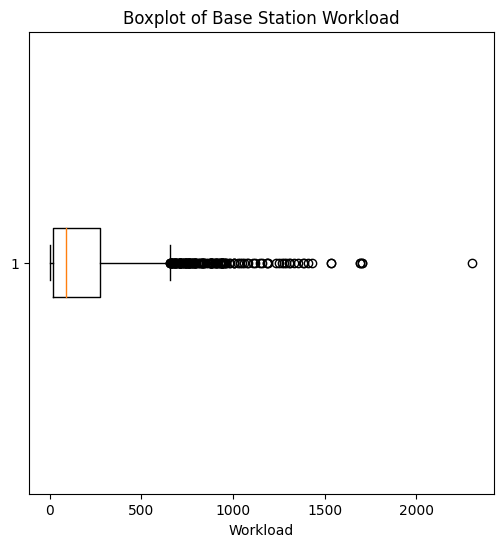

In [24]:
# Workload distribution histogram
plt.figure(figsize=(10, 6))
plt.hist(base_stations['workload'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Base Station Workload')
plt.xlabel('Workload')
plt.ylabel('Frequency')
plt.show()

# Workload boxplot
plt.figure(figsize=(6, 6))
plt.boxplot(base_stations['workload'], vert=False)
plt.title('Boxplot of Base Station Workload')
plt.xlabel('Workload')
plt.show()


In [25]:
fig = px.scatter_mapbox(base_stations,
                        lat="latitude",
                        lon="longitude",
                        color="workload",
                        size="workload",  # Bubble size can reflect workload too
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=15,
                        zoom=10,
                        mapbox_style="carto-positron",  # You can change the map style
                        title="Base Stations Workload Distribution")

fig.show()

In [26]:
fig = px.density_mapbox(base_stations,
                        lat="latitude",
                        lon="longitude",
                        z="workload",  
                        radius=10,  
                        center=dict(lat=31.2304, lon=121.4737),  # Center on Shanghai
                        zoom=10,
                        mapbox_style="stamen-terrain",  
                        title="Heatmap of Base Station Workload")


fig.show()

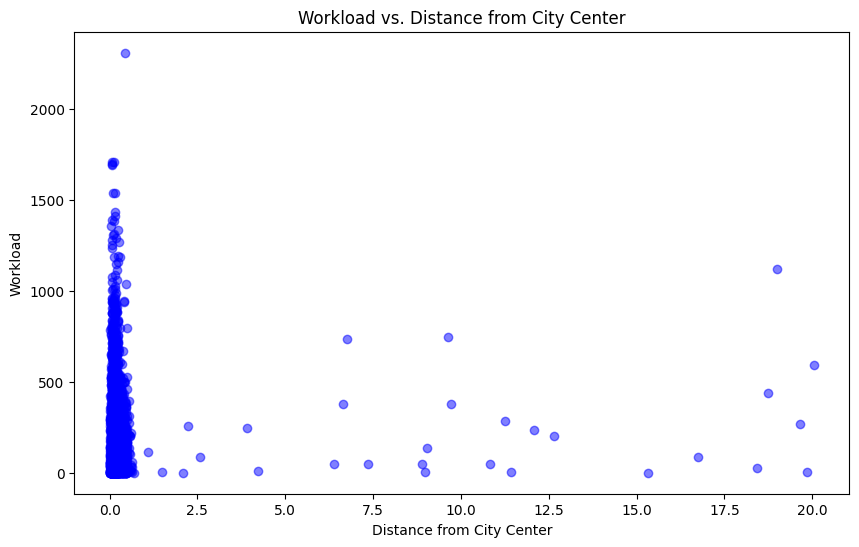

In [34]:

city_center_lat = base_stations['latitude'].mean()
city_center_lon = base_stations['longitude'].mean()


base_stations['distance_to_center'] = np.sqrt((base_stations['latitude'] - city_center_lat)**2 + (base_stations['longitude'] - city_center_lon)**2)


plt.figure(figsize=(10, 6))
plt.scatter(base_stations['distance_to_center'], base_stations['workload'], alpha=0.5, c='blue')
plt.title('Workload vs. Distance from City Center')
plt.xlabel('Distance from City Center')
plt.ylabel('Workload')
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/tmp/ipykernel_30/3733570656.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



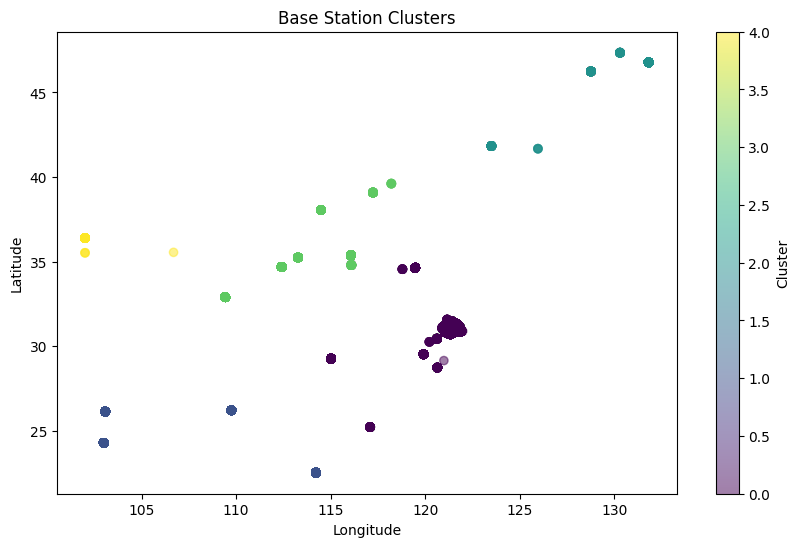

In [32]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
df_clean['cluster'] = kmeans.fit_predict(df_clean[['latitude_norm', 'longitude_norm']])

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['longitude'], df_clean['latitude'], c=df_clean['cluster'], cmap='viridis', alpha=0.5)
plt.title('Base Station Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()


In [41]:
base_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705 entries, 0 to 2704
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            2705 non-null   float64
 1   longitude           2705 non-null   float64
 2   workload            2705 non-null   int64  
 3   distance_to_center  2705 non-null   float64
 4   coordinates         2705 non-null   object 
dtypes: float64(3), int64(1), object(1)
memory usage: 105.8+ KB
